# Preprocessing - Converting to images

Raw malwares will be stored in the following folder:

In [286]:
root = "D:/YOLOV5 AND LABELIMG TOOLS/malimg_paper_dataset_imgs"

In [287]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

## This function allows us to process our hexadecimal files into png images##
def convertAndSave(array,name):
    print('Processing '+name)
    if array.shape[1]!=16: #If not hexadecimal
        assert(False)
    b=int((array.shape[0]*16)**(0.5))
    b=2**(int(log(b)/log(2))+1)
    a=int(array.shape[0]*16/b)
    array=array[:a*b//16,:]
    array=np.reshape(array,(a,b))
    im = Image.fromarray(np.uint8(array))
    im.save(root+'\\'+name+'.png', "PNG")
    return im

#Get the list of files
files=os.listdir(root)
print('files : ',files)
#We will process files one by one.
for counter, name in enumerate(files):
        #We only process .bytes files from our folder.
        if '.bytes' != name[-6:]:
            continue
        f=open(root+'/'+name)
        array=[]
        for line in f:
            xx=line.split()
            if len(xx)!=17:
                continue
            array.append([int(i,16) if i!='??' else 0 for i in xx[1:] ])
        plt.imshow(convertAndSave(np.array(array),name))
        del array
        f.close()

files :  ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.gen!g', 'C2LOP.P', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


# Preprocessing - Generate the dataset

Here is our new folder :

In [366]:
path_root = "D:/YOLOV5 AND LABELIMG TOOLS/malimg_paper_dataset_imgs"

In [367]:
from keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [368]:
# labels = ["Adialer.C", 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.P',
#           'C2LOP.gen!g','Dialplatform.B', 'Dontovo.A', 'Fakerean','Instantaccess','Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3',
#           'Lolyda.AT','Malex.gen!J','Obfuscator.AD', 'Rbot!gen, 'Skintrim.N, 'Swizzor.gen!E', 'Swizzor.gen!I,
#             'VB.AT', 'Wintrim.BX, 'Yuner.A']


In [369]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [370]:
imgs, labels = next(batches)

In [371]:
imgs.shape

(9339, 64, 64, 3)

In [372]:
labels.shape

(9339, 25)

The following method allows us to plot a sample of images in our dataset.

In [373]:
import numpy as np
import matplotlib.pyplot as plt

In [374]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

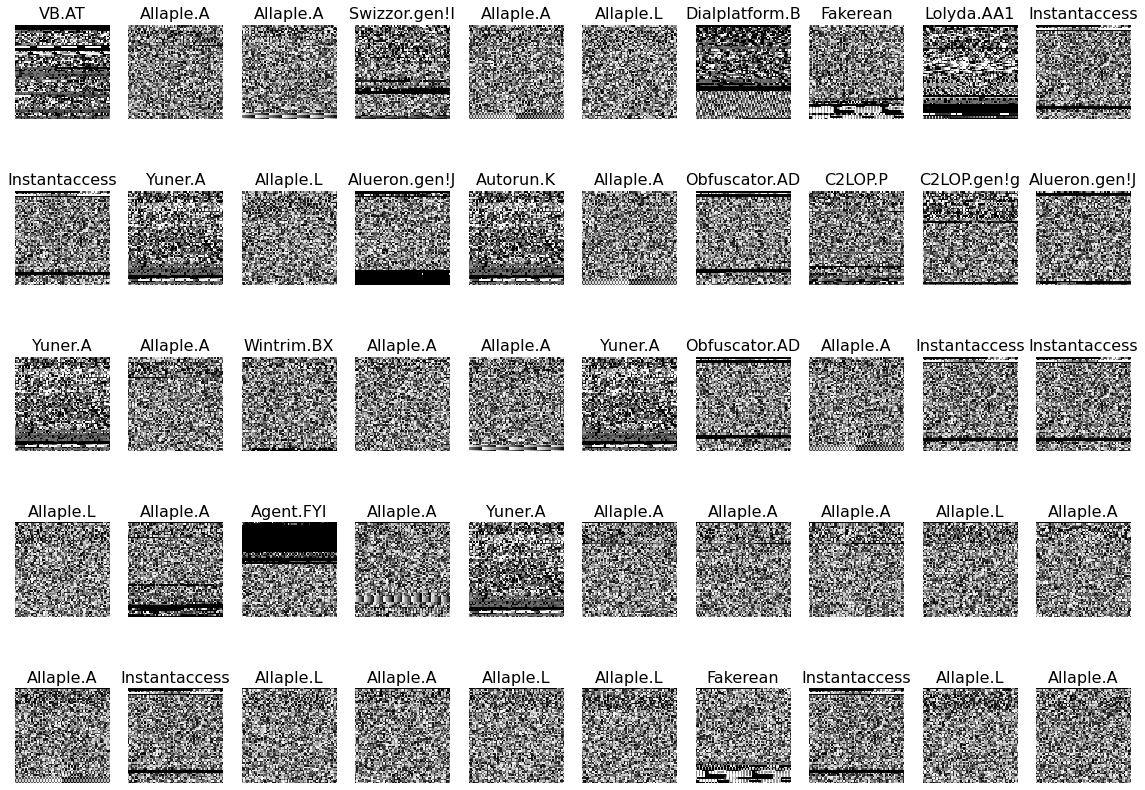

In [375]:
plots(imgs, titles = labels)

# Analyse 

In [376]:
classes = batches.class_indices.keys()

In [377]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

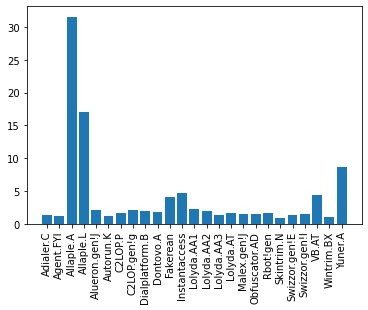

In [378]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

# Train and test

Lets split our model into train and test following a ratio 70% train - 30% test ratio.

In [379]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [380]:
X_train.shape

(6537, 64, 64, 3)

In [381]:
X_test.shape

(2802, 64, 64, 3)

In [382]:
y_train.shape

(6537, 25)

In [383]:
y_test.shape

(2802, 25)

## Convolutional Neural Network Model

In [384]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization

We want **25** classes as output.

In [385]:
num_classes = 25

Building the model

In [386]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [387]:
Malware_model = malware_model()

In [388]:
Malware_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 30)        840       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 15)        4065      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 15)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 15)        0         
                                                                 
 flatten_5 (Flatten)         (None, 2940)             

In [389]:
y_train.shape

(6537, 25)

In [390]:
y_train_new = np.argmax(y_train, axis=1)

In [391]:
y_train_new

array([22,  2,  2, ..., 19, 24, 24], dtype=int64)

In [392]:
'''from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.any()(y_train_new),
                                                 y_train_new)'''

"from sklearn.utils import class_weight\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                 np.any()(y_train_new),\n                                                 y_train_new)"

In [393]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10 )  #class_weight=class_weights)

Epoch 1/10
205/205 [==============================] - 38s 161ms/step - loss: 1.7252 - accuracy: 0.4819 - val_loss: 0.8300 - val_accuracy: 0.6767
Epoch 2/10
205/205 [==============================] - 33s 161ms/step - loss: 0.7272 - accuracy: 0.7805 - val_loss: 0.3397 - val_accuracy: 0.8954
Epoch 3/10
205/205 [==============================] - 35s 171ms/step - loss: 0.4266 - accuracy: 0.8715 - val_loss: 0.2566 - val_accuracy: 0.9243
Epoch 4/10
205/205 [==============================] - 32s 158ms/step - loss: 0.3171 - accuracy: 0.9021 - val_loss: 0.2283 - val_accuracy: 0.9304
Epoch 5/10
205/205 [==============================] - 32s 155ms/step - loss: 0.2733 - accuracy: 0.9128 - val_loss: 0.2015 - val_accuracy: 0.9343
Epoch 6/10
205/205 [==============================] - 32s 154ms/step - loss: 0.2383 - accuracy: 0.9235 - val_loss: 0.1637 - val_accuracy: 0.9472
Epoch 7/10
205/205 [==============================] - 31s 151ms/step - loss: 0.1997 - accuracy: 0.9364 - val_loss: 0.1754 - val_ac

In [394]:
scores = Malware_model.evaluate(X_test, y_test)   

88/88 [==============================] - 4s 44ms/step - loss: 0.1485 - accuracy: 0.9582


We got a 95% accuracy which is not bad !

In [395]:
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.9582440853118896


In [396]:
Malware_model.save("Malware CNN.h5")    # save model

# Confusion Matrix

Lets analyse our results.

In [397]:
import numpy as np
import pandas as pd
y_test.shape

(2802, 25)

In [398]:
y_pred = Malware_model.predict(X_test, verbose=0) # update code "predict" not predict_classess
y_pred.shape

(2802, 25)

In [399]:
#y_pred.shape

In [400]:
#y_test2 = np.argmax(y_test, axis=1)

In [401]:
'''
# convert integers to dummy variables (i.e. one hot encoded)
from keras.utils.np_utils import to_categorical
import numpy as np
y_test1 = to_categorical(y_test)
y_test1.shape'''

'\n# convert integers to dummy variables (i.e. one hot encoded)\nfrom keras.utils.np_utils import to_categorical\nimport numpy as np\ny_test1 = to_categorical(y_test)\ny_test1.shape'

In [402]:
#y_test2.shape

In [403]:
#  install or update scikit-learn
# conda update scikit-learn
# from sklearn.metrics import multilabel_confusion_matrix


In [404]:
#len(y_test1)

In [405]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

#classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [406]:
#confusion_matrix(y_test, y_pred)

In [407]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

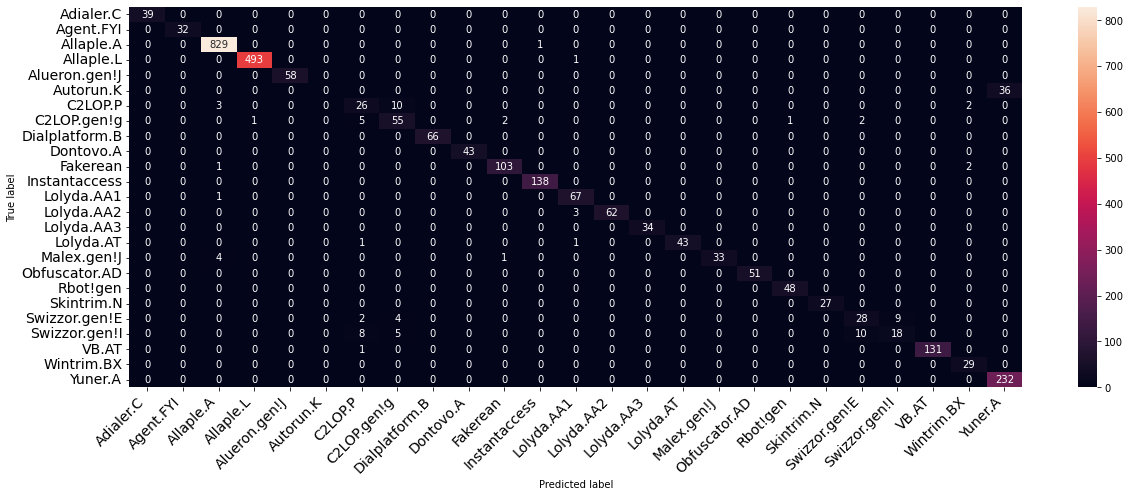

In [408]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)